In [1]:
import pandas as pd
from pandas.io.json import build_table_schema
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import scipy as sp
import os
import xgboost as xgb
#import visualization as vis
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

DIR_PATH = './'

## Columns/features currently in use

In [2]:
train  = pd.read_csv("train_top20_partClean.csv")
test = pd.read_csv("test_top20_partClean.csv")
print train.columns.values
print 40 * '*'
print test.columns.values

['id' 'timestamp' 'full_sq' 'life_sq' 'floor' 'build_year' 'max_floor'
 'kitch_sq' 'num_room' 'state' 'kindergarten_km' 'green_zone_km'
 'school_km' 'metro_min_avto' 'public_healthcare_km' 'sub_area'
 'industrial_km' 'metro_min_walk' 'railroad_km' 'swim_pool_km' 'material'
 'price_doc']
****************************************
['id' 'timestamp' 'full_sq' 'life_sq' 'floor' 'build_year' 'max_floor'
 'kitch_sq' 'num_room' 'state' 'kindergarten_km' 'green_zone_km'
 'school_km' 'metro_min_avto' 'public_healthcare_km' 'sub_area'
 'industrial_km' 'metro_min_walk' 'railroad_km' 'swim_pool_km' 'material']


## The datatypes for each column

In [3]:
g = train.columns.to_series().groupby(train.dtypes).groups
g

{dtype('int64'): Index([u'id', u'full_sq', u'price_doc'], dtype='object'),
 dtype('float64'): Index([u'life_sq', u'floor', u'build_year', u'max_floor', u'kitch_sq',
        u'num_room', u'state', u'kindergarten_km', u'green_zone_km',
        u'school_km', u'metro_min_avto', u'public_healthcare_km',
        u'industrial_km', u'metro_min_walk', u'railroad_km', u'swim_pool_km',
        u'material'],
       dtype='object'),
 dtype('O'): Index([u'timestamp', u'sub_area'], dtype='object')}

In [4]:
## some simple feauture engineering from Shu. NOT SURE WHY DIDN'T STORE IN THE CSV 
#log transformation
train.loc[:, 'log_price_doc'] = np.log(train['price_doc'] + 1)
## time features

# train.loc[:, 'year'] = train.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
# train.loc[:, 'month'] = train.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))
# test.loc[:, 'year'] = test.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
# test.loc[:, 'month'] = test.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

train.loc[:, 'year'] =  train.loc[:,'timestamp'].apply(lambda x: x[0:4])
train.loc[:, 'month'] =  train.loc[:, 'timestamp'].apply(lambda x: x[5:7])
test.loc[:, 'year'] = test.loc[:, 'timestamp'].apply(lambda x: x[0:4])
test.loc[:, 'month'] = test.loc[:, 'timestamp'].apply(lambda x: x[0:4])

## property square meters
train.loc[:,'year'] = train.loc[:, 'sq_metr'] = train.loc[:, ['full_sq','life_sq']].max(axis=1)

## property unit_price
train.loc[:, 'unit_price'] = train.loc[:, 'price_doc'] / train.loc[:, 'sq_metr']
train.loc[train['unit_price'] > 600000, 'unit_price'] = np.nan

## sub_area
freq_area = np.array(train.loc[:, 'sub_area'].value_counts()[:60].index)
train.loc[~train['sub_area'].isin(freq_area), 'sub_area'] = 'other'
test.loc[~test['sub_area'].isin(freq_area), 'sub_area'] = 'other'


In [5]:
## label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = dict()

for feature in ['sub_area']:
    print('encoding feature: {}'.format(feature))
    label_encoder[feature] = LabelEncoder()
    label_encoder[feature].fit(train[feature])
    train.loc[:, feature + '_le'] = label_encoder[feature].transform(train[feature])
    test.loc[:, feature + '_le'] = label_encoder[feature].transform(test[feature])

encoding feature: sub_area


In [6]:
print train.columns.values
print("The number of columns after slight feature engineering is {:.2f}".format(len(list(train.columns.values))))

['id' 'timestamp' 'full_sq' 'life_sq' 'floor' 'build_year' 'max_floor'
 'kitch_sq' 'num_room' 'state' 'kindergarten_km' 'green_zone_km'
 'school_km' 'metro_min_avto' 'public_healthcare_km' 'sub_area'
 'industrial_km' 'metro_min_walk' 'railroad_km' 'swim_pool_km' 'material'
 'price_doc' 'log_price_doc' 'year' 'month' 'sq_metr' 'unit_price'
 'sub_area_le']
The number of columns after slight feature engineering is 28.00


In [40]:
g = train.columns.to_series().groupby(train.dtypes).groups
g # The year is a float and maybe it should be a categorical variable. 

{dtype('int64'): Index([u'id', u'full_sq', u'price_doc', u'sub_area_le'], dtype='object'),
 dtype('float64'): Index([u'life_sq', u'floor', u'build_year', u'max_floor', u'kitch_sq',
        u'num_room', u'state', u'kindergarten_km', u'green_zone_km',
        u'school_km', u'metro_min_avto', u'public_healthcare_km',
        u'industrial_km', u'metro_min_walk', u'railroad_km', u'swim_pool_km',
        u'material', u'log_price_doc', u'year', u'sq_metr', u'unit_price'],
       dtype='object'),
 dtype('O'): Index([u'timestamp', u'sub_area', u'month'], dtype='object')}

In [7]:
model_features  = ['full_sq', 'life_sq', 'floor', 'build_year',
                   'max_floor', 'kitch_sq', 'num_room', 'state', 'kindergarten_km',
                   'green_zone_km', 'school_km', 'metro_min_avto',
                   'public_healthcare_km', 'industrial_km',
                   'metro_min_walk', 'railroad_km', 'swim_pool_km', 'material',
                   'sub_area_le']

model_features_noMissing = ['full_sq','kindergarten_km','green_zone_km', 'school_km', 'metro_min_avto',
                            'public_healthcare_km', 'industrial_km', 'railroad_km', 'swim_pool_km','sub_area_le',
                            'year','month']


X_train = train[model_features_noMissing].values
Y_train = train['log_price_doc'].values
X_test = test[model_features_noMissing].values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)


(30471, 12)
(30471,)
(7662, 12)


# Checking that we are no longer using missing data

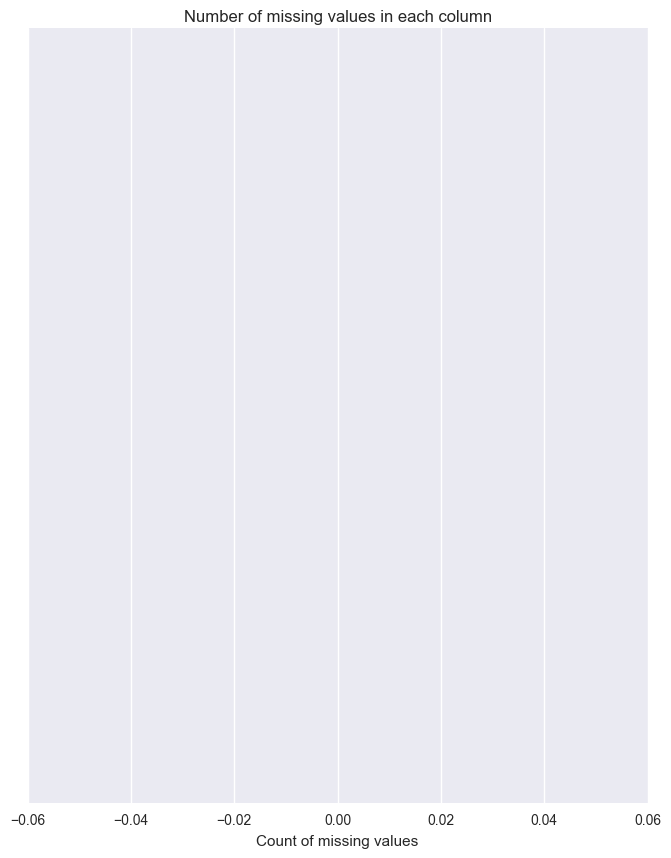

array([], dtype=object)

In [8]:
missing_df = train[['timestamp','full_sq', 'kindergarten_km','green_zone_km', 'school_km', 'metro_min_avto',
                            'public_healthcare_km', 'industrial_km', 'railroad_km', 'swim_pool_km','sub_area_le']].isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
ind = np.arange(missing_df.shape[0])
width =  0.9 
fig, ax = plt.subplots(figsize=(8,10))
rects = ax.barh(ind, missing_df.missing_count.values, color ='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()
missing_df.loc[:,'column_name'].values

# Modelling:
## Here we go! The first model of interest is the Random Forest. 
## We want to use this first, since we have't scaled the features (yet) and they don't require heavy tuning.
## Note: Will go back to use simple Decision Tree, because we want to have some representation of the decision making. BOOM!

## The important features to adjust are n_estimators, max_features, and max depth. For n_estimators larger is always better.  Smaller max_features reduces overfitting.

## Empirical good default values are max_features=n_features for regression problems




In [9]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
n_features = X_train.shape[1] # Random Forest cannot handle missing data

forest = RandomForestRegressor(n_estimators=100, random_state= 2, max_features=n_features)
forest.fit(X_train, Y_train) 


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [12]:
import math 
log_y_test = forest.predict(X_test)
log_y_test

array([ 15.61170286,  16.0742473 ,  15.57420768, ...,  15.38751036,
        15.44879787,  15.99300915])

In [13]:
print("The R^2 on the training set:  {:.6f}".format(forest.score(X_train, Y_train)))

The R^2 on the training set:  0.905148


## The R^2 on the training set:  0.878585 (only features with no missing data) 
## The R^2 on the training set:  0.911619 with the year and month added as features


In [14]:
y_pred = np.exp(log_y_test) - 1

In [15]:
submit = pd.DataFrame({'id': np.array(test.index)+30474, 'price_doc': y_pred})
submit.to_csv('submission.csv', index=False)

# Ridge Regression:  L2. So we are wanting learn two things from this model. 1) Implement a cross-validation 5-fold method to determine the coffiecient lambda/alpha. 2) Scale that data down!  We need to have all the features on the same scale. Let's get to work! 

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler # All the features will be between 0 and 1 

In [44]:
#Currently we don't have that many variables 12 and we are probably not overfitting. 

#Scaling it!
scaler = MinMaxScaler() 
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [45]:
X_train_scaled = scaler.transform(X_train)

In [46]:
print("transformed shape {}".format(X_train_scaled.shape))
print("per-feature minimum before scaling {}".format(X_train.min(axis=0)))
print("per-feature maximum before scaling {}".format(X_train.max(axis=0)))
print 20 * '-' + "Some Day I'm going to Scale that Mountain!" + 20 * '-'
print("per-feature minimum after scaling {}".format(X_train_scaled.min(axis=0)))
print("per-feature maximum after scaling {}".format(X_train_scaled.max(axis=0)))
print "Scaled it!"
X_test_scaled = scaler.transform(X_test)

transformed shape (30471, 12)
per-feature minimum before scaling [0 0.00046974800000000003 0.0 0.0 0.0 0.0 0.0 0.0022994820000000003 0.0 0
 0.0 '01']
per-feature maximum before scaling [5326 29.08577383 1.9824481090000001 47.39470605 61.43847178 76.05513511
 14.04816211 17.387118899999997 53.35929368 60 7478.0 '12']
--------------------Some Day I'm going to Scale that Mountain!--------------------
per-feature minimum after scaling [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
per-feature maximum after scaling [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Scaled it!


In [47]:
# prepare a range of alpha values to test
param_grid = {'alpha': [10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(Ridge(), param_grid, cv=5)
grid.fit(X_train_scaled,Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [10, 1, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [48]:
print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation score: {:.3f}".format(grid.best_score_))

Best parameters: {'alpha': 1}
Best cross-validation score: 0.073


In [49]:
results = pd.DataFrame(grid.cv_results_)
results # change this to show the entire DF 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.013369,0.000771,0.052202,0.084751,10,{u'alpha': 10},2,-0.043706,0.102603,0.093571,...,0.077299,0.084845,0.076066,0.081476,0.057795,0.075820,0.004315,0.000254,0.049278,0.009403
1,0.008856,0.000596,0.072600,0.136331,1,{u'alpha': 1},1,-0.175069,0.211049,0.159287,...,0.118135,0.125467,0.135388,0.118433,0.125300,0.110937,0.001574,0.000274,0.124623,0.037653
2,0.007898,0.000445,-0.101198,0.163473,0.1,{u'alpha': 0.1},3,-1.154872,0.312345,0.193292,...,0.127391,0.132107,0.166635,0.127933,0.161737,0.119870,0.000470,0.000030,0.527298,0.074542
3,0.007922,0.000591,-0.209906,0.165725,0.01,{u'alpha': 0.01},4,-1.721797,0.322308,0.199155,...,0.133152,0.132239,0.172057,0.128331,0.168150,0.120243,0.000411,0.000210,0.756299,0.078389
4,0.007758,0.000449,-0.225021,0.165761,0.001,{u'alpha': 0.001},5,-1.803083,0.322470,0.199797,...,0.136933,0.132241,0.172652,0.128337,0.168856,0.120248,0.000172,0.000028,0.789348,0.078452
5,0.007710,0.000436,-0.226554,0.165761,0.0001,{u'alpha': 0.0001},6,-1.811557,0.322471,0.199862,...,0.137547,0.132242,0.172712,0.128337,0.168927,0.120248,0.000432,0.000045,0.792813,0.078452
6,0.007936,0.000472,-0.226724,0.165761,0,{u'alpha': 0},7,-1.812502,0.322471,0.199869,...,0.137620,0.132242,0.172719,0.128337,0.168935,0.120248,0.000424,0.000070,0.793200,0.078452


In [54]:
print("The R^2 on the training set:  {:.6f}".format(grid.score(X_train_scaled, Y_train)))

The R^2 on the training set:  0.130474


In [56]:
log_y_test_L2 =grid.predict(X_test_scaled)
y_pred = np.exp(log_y_test) - 1

(array([  3.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          1.05000000e+02,   2.97000000e+02,   9.51000000e+02,
          5.68100000e+03,   6.13000000e+02,   6.00000000e+00,
          1.00000000e+00]),
 array([  9.14426498,   9.38420654,   9.6241481 ,   9.86408966,
         10.10403122,  10.34397278,  10.58391434,  10.8238559 ,
         11.06379746,  11.30373902,  11.54368058]),
 <a list of 10 Patch objects>)

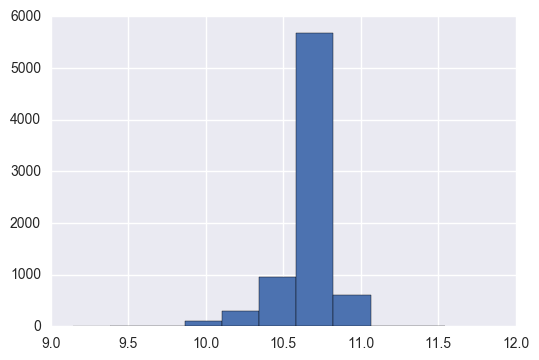

In [58]:
plt.hist(log_y_test_L2) # The finger from Ridge.  